# Anomaly Detection Challenge

This notebook experiments with different anomaly detection algorithms on the HEP dataset.
We'll compare Isolation Forest and Flow Matching approaches.

In [1]:
# Import necessary libraries
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    RocCurveDisplay,
)
import time

# Import fAD components
from fad.data.loaders import _load_h5_challenge_dataset
from fad.data.preprocessing import Preprocessor, StandardScalerFunction, TSNEFunction
from fad.models.statistical import IsolationForestDetector
from fad.models.flow_matching import FlowMatchingAnomalyDetector
from fad.models.NNs import MLP_wrapper

/home/fvaselli/miniconda3/envs/AD/lib/python3.12/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.stats import gaussian_kde


In [2]:
import hls4ml

## 1. Data Loading and Exploration

In [3]:
# Set paths to dataset files
path_bkg = (
    "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
)
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=3500000, n_test=60000)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")

# dataset 2 with different anomaly process
path_anom2 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset2 = _load_h5_challenge_dataset(
    path_bkg, path_anom2, n_train=100000, n_test=400000
)
# Print dataset information
print(f"Training set shape: {dataset2.train.shape}")
print(f"Test set shape: {dataset2.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset2.test_labels)}")

path_anom3 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/hToTauTau_13TeV_PU20_filtered.h5"
# Load challenge datasets
print("Loading datasets...")
dataset3 = _load_h5_challenge_dataset(
    path_bkg, path_anom3, n_train=100000, n_test=400000
)
# Print dataset information
print(f"Training set shape: {dataset3.train.shape}")
print(f"Test set shape: {dataset3.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset3.test_labels)}")

path_anom4 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/hChToTauNu_13TeV_PU20_filtered.h5"
# Load challenge datasets
print("Loading datasets...")
dataset4 = _load_h5_challenge_dataset(
    path_bkg, path_anom4, n_train=100000, n_test=400000
)
# Print dataset information
print(f"Training set shape: {dataset4.train.shape}")
print(f"Test set shape: {dataset4.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset4.test_labels)}")


Loading datasets...
Discarding type index, shape bkg: (3560000, 19, 3), shape anom: (55969, 19, 3)
Training set shape: (3500000, 57)
Test set shape: (115969, 57)
Number of anomalies in test set: 55969.0
Loading datasets...
Discarding type index, shape bkg: (500000, 19, 3), shape anom: (340544, 19, 3)
Training set shape: (100000, 57)
Test set shape: (740544, 57)
Number of anomalies in test set: 340544.0
Loading datasets...
Discarding type index, shape bkg: (500000, 19, 3), shape anom: (400000, 19, 3)
Training set shape: (100000, 57)
Test set shape: (800000, 57)
Number of anomalies in test set: 400000.0
Loading datasets...
Discarding type index, shape bkg: (500000, 19, 3), shape anom: (400000, 19, 3)
Training set shape: (100000, 57)
Test set shape: (800000, 57)
Number of anomalies in test set: 400000.0


## 2. Data Preprocessing

In [4]:
# Preprocess data with standardization
print("Preprocessing data...")
preprocessor = Preprocessor([StandardScalerFunction()])
X_train = preprocessor.transform(dataset.train, fit=True)
X_test = preprocessor.transform(dataset.test)
print("Done")
X_test2 = preprocessor.transform(dataset2.test)
X_test3 = preprocessor.transform(dataset3.test)
X_test4 = preprocessor.transform(dataset4.test)

Preprocessing data...


Done


## 4. Train and Evaluate Models

We'll train and evaluate two models:
1. Isolation Forest (traditional algorithm)
2. Flow Matching (advanced generative model)

In [5]:
# Dictionary to store results
results = {}

### 4.2 Flow Matching

In [6]:
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
flow_matching = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size=config["batch_size"],
    reflow_steps=config["reflow_steps"],
    reflow_batches=config["reflow_batches"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
)
flow_matching.load("last_model.pt")

# print("Training Flow Matching (this may take a while)...")
# # load the model config from the config file
# # use absolute path to avoid issues with relative paths: get my parent folder, then go to fad/models/configs/flow_matching.yaml
# config_path = "../fad/models/configs/flow_matching.yaml"
# with open(config_path, "r") as f:
#     config = yaml.safe_load(f)
# start_time = time.time()
# flow_matching = FlowMatchingAnomalyDetector(
#     input_dim=X_train.shape[1],
#     hidden_dim=config["hidden_dim"],
#     model_type=config["model_type"],
#     num_layers=config["num_layers"],
#     dropout_rate=config["dropout_rate"],
#     use_batch_norm=config["use_batch_norm"],
#     lr=config["lr"],
#     batch_size=config["batch_size"],
#     reflow_steps=config["reflow_steps"],
#     reflow_batches=config["reflow_batches"],
#     iterations=config["iterations"],
#     print_every=config["print_every"],
#     device=config["device"],
# )
# flow_matching.fit(X_train, mode="OT", reflow=False)
# flow_time = time.time() - start_time
# print(f"Training time: {flow_time:.2f} seconds")
# print(f"Number of parameters in the model:{sum(p.numel() for p in flow_matching.vf.parameters() if p.requires_grad)}")

Model loaded from last_model.pt


/home/fvaselli/Documents/PHD/fAD/fad/models/flow_matching.py:545: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.vf.load_state_dict(torch.load(path))


In [7]:
# save the model
# flow_matching.save("last_model.pt")

In [8]:
# get it to hls format
hls_model_no_einsum = flow_matching.return_model_for_hls()
precisions = [
    (32, 16),
]
hls_models = {}  # Dictionary to store the hls4ml models
for i, (integer, fraction) in enumerate(precisions):
    precision_string = f"ap_fixed<{integer}, {fraction}>"
    output_dir = f"model_{integer}_{fraction}/hls4ml_prj"  # Unique output directory for each model

    print(f"Converting model with precision: {precision_string}")

    # convert the model to hls4ml
    config = hls4ml.utils.config_from_pytorch_model(
        hls_model_no_einsum,
        input_shape=(58,),
        granularity="name",
        backend="Vitis",
        default_precision=precision_string,
    )
    print("-----------------------------------")
    print("Configuration")
    # plotting.print_dict(config)
    for layer in config["LayerName"].keys():
        config["LayerName"][layer]["Trace"] = True

    if precision_string == "ap_fixed<18, 10>":
        config["LayerName"]["main_0"]["Precision"]["weight"] = "ap_fixed<22,10>"
        config["LayerName"]["main_6"]["Precision"]["weight"] = "ap_fixed<22,10>"
    

    print("-----------------------------------")
    hls_model_no_einsum = hls4ml.converters.convert_from_pytorch_model(
        hls_model_no_einsum,
        hls_config=config,
        backend="Vitis",
        output_dir=output_dir,
        part="xcu250-figd2104-2L-e",
    )
    hls_models[precision_string] = hls_model_no_einsum  # Store the model in the dictionary

    if precision_string == "ap_fixed<18, 10>":
        hls4ml.utils.plot_model(
            hls_model_no_einsum, show_shapes=True, show_precision=True, to_file=None
        )

Converting model with precision: ap_fixed<32, 16>
-----------------------------------
Configuration
-----------------------------------
Interpreting Model ...
Topology:
Layer name: main_0, layer type: Dense, input shape: [[None, 58]]
Layer name: main_1, layer type: Activation, input shape: [[None, 32]]
Layer name: main_2, layer type: Dense, input shape: [[None, 32]]
Layer name: main_3, layer type: Activation, input shape: [[None, 32]]
Layer name: main_4, layer type: Dense, input shape: [[None, 32]]
Layer name: main_5, layer type: Activation, input shape: [[None, 32]]
Layer name: main_6, layer type: Dense, input shape: [[None, 32]]
Creating HLS model


In [9]:
# get it to hls format
hls_model_einsum = flow_matching.return_model_for_hls(mode="einsum")
precisions = [
    (18, 10),
]
hls_models = {}  # Dictionary to store the hls4ml models
for i, (integer, fraction) in enumerate(precisions):
    precision_string = f"ap_fixed<{integer}, {fraction}>"
    output_dir = f"model_{integer}_{fraction}/hls4ml_prj"  # Unique output directory for each model

    print(f"Converting model with precision: {precision_string}")

    # convert the model to hls4ml
    config = hls4ml.utils.config_from_pytorch_model(
        hls_model_einsum,
        input_shape=(58,),
        granularity="name",
        backend="Vitis",
        default_precision=precision_string,
    )
    print("-----------------------------------")
    print("Configuration")
    # plotting.print_dict(config)
    for layer in config["LayerName"].keys():
        config["LayerName"][layer]["Trace"] = True

    if precision_string == "ap_fixed<18, 10>":
        config["LayerName"]["main_0"]["Precision"]["weight"] = "ap_fixed<22,10>"
        config["LayerName"]["main_6"]["Precision"]["weight"] = "ap_fixed<22,10>"
        
    config["LayerName"]["einsum"]["Precision"] = "ap_fixed<64,32, AP_RND, AP_SAT>"
    
    # config["LayerName"]["einsum"]["accum_t"] = "ap_fixed<16,16, AP_RND, AP_SAT>"
    # config["LayerName"]["einsum"]["result_t"] = "ap_fixed<16,16, AP_RND, AP_SAT>"

    
    print("-----------------------------------")
    hls_model_einsum = hls4ml.converters.convert_from_pytorch_model(
        hls_model_einsum,
        hls_config=config,
        backend="Vitis",
        output_dir=output_dir,
        part="xcu250-figd2104-2L-e",
    )
    hls_models[precision_string] = hls_model_einsum  # Store the model in the dictionary

    if precision_string == "ap_fixed<18, 10>":
        hls4ml.utils.plot_model(
            hls_model_einsum, show_shapes=True, show_precision=True, to_file=None
        )

Converting model with precision: ap_fixed<18, 10>
-----------------------------------
Configuration
-----------------------------------
Interpreting Model ...
Topology:
Layer name: main_0, layer type: Dense, input shape: [[None, 58]]
Layer name: main_1, layer type: Activation, input shape: [[None, 32]]
Layer name: main_2, layer type: Dense, input shape: [[None, 32]]
Layer name: main_3, layer type: Activation, input shape: [[None, 32]]
Layer name: main_4, layer type: Dense, input shape: [[None, 32]]
Layer name: main_5, layer type: Activation, input shape: [[None, 32]]
Layer name: main_6, layer type: Dense, input shape: [[None, 32]]
Layer name: einsum, layer type: Einsum, input shape: [[None, 57], [None, 57]]
Creating HLS model
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [10]:
# # get it to hls format
# hls_model_sum = flow_matching.return_model_for_hls(mode="sum")
# precisions = [
#     (32, 16),
# ]
# hls_models = {}  # Dictionary to store the hls4ml models
# for i, (integer, fraction) in enumerate(precisions):
#     precision_string = f"ap_fixed<{integer}, {fraction}>"
#     output_dir = f"model_{integer}_{fraction}/hls4ml_prj"  # Unique output directory for each model

#     print(f"Converting model with precision: {precision_string}")

#     # convert the model to hls4ml
#     config = hls4ml.utils.config_from_pytorch_model(
#         hls_model_sum,
#         input_shape=(58,),
#         granularity="name",
#         backend="Vitis",
#         default_precision=precision_string,
#     )
#     print("-----------------------------------")
#     print("Configuration")
#     # plotting.print_dict(config)
#     for layer in config["LayerName"].keys():
#         config["LayerName"][layer]["Trace"] = True

#     if precision_string == "ap_fixed<18, 10>":
#         config["LayerName"]["main_0"]["Precision"]["weight"] = "ap_fixed<22,10>"
#         config["LayerName"]["main_6"]["Precision"]["weight"] = "ap_fixed<22,10>"
    

#     print("-----------------------------------")
#     hls_model_sum = hls4ml.converters.convert_from_pytorch_model(
#         hls_model_sum,
#         hls_config=config,
#         backend="Vitis",
#         output_dir=output_dir,
#         part="xcu250-figd2104-2L-e",
#     )
#     hls_models[precision_string] = hls_model_sum  # Store the model in the dictionary

#     if precision_string == "ap_fixed<18, 10>":
#         hls4ml.utils.plot_model(
#             hls_model_sum, show_shapes=True, show_precision=True, to_file=None
#         )

In [11]:
hls_model_einsum.compile()
hls_model_no_einsum.compile()
# hls_model_sum.compile()

Writing HLS project
Done
Writing HLS project
Done


In [12]:
# create the right input for the HLS model: our input dataset + the time stamp fixed to 1
X_test_hls = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
X_test_hls2 = np.concatenate((X_test2, np.ones((X_test2.shape[0], 1))), axis=1)
X_test_hls3 = np.concatenate((X_test3, np.ones((X_test3.shape[0], 1))), axis=1)
X_test_hls4 = np.concatenate((X_test4, np.ones((X_test4.shape[0], 1))), axis=1)
# predict with the HLS model
# predict anomaly scores
hls_datasets= {"test": X_test_hls} #, "test2": X_test_hls2, "test3": X_test_hls3, "test4": X_test_hls4 }

Profiling model
Interpreting Model ...
Topology:
Layer name: main_0, layer type: Dense, input shape: [[None, 58]]
Layer name: main_1, layer type: Activation, input shape: [[None, 32]]
Layer name: main_2, layer type: Dense, input shape: [[None, 32]]
Layer name: main_3, layer type: Activation, input shape: [[None, 32]]
Layer name: main_4, layer type: Dense, input shape: [[None, 32]]
Layer name: main_5, layer type: Activation, input shape: [[None, 32]]
Layer name: main_6, layer type: Dense, input shape: [[None, 32]]
Layer name: einsum, layer type: Einsum, input shape: [[None, 57], [None, 57]]
Creating HLS model
Profiling weights (before optimization)
[{'med': np.float32(0.034406185), 'q1': np.float32(0.006826298), 'q3': np.float32(0.12550135), 'whislo': np.float32(1.5538535e-07), 'whishi': np.float32(3.2018993), 'layer': 'main_0', 'weight': 'main_0/w'}, {'med': np.float32(2.5628467), 'q1': np.float32(2.2135935), 'q3': np.float32(2.8932233), 'whislo': np.float32(1.2612754), 'whishi': np.fl

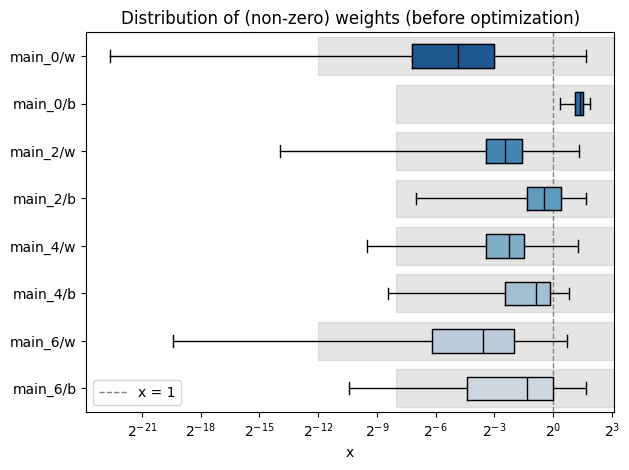

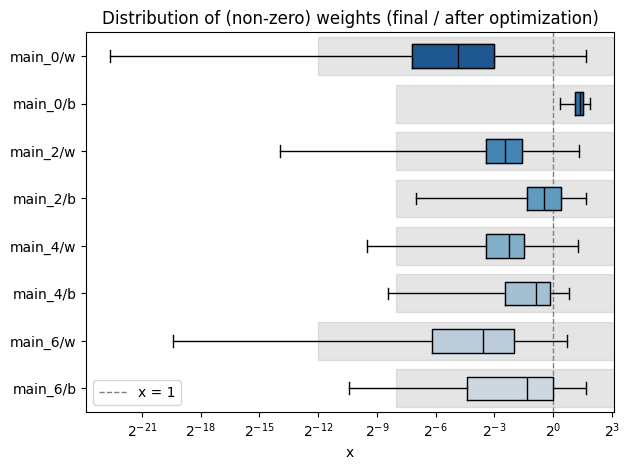

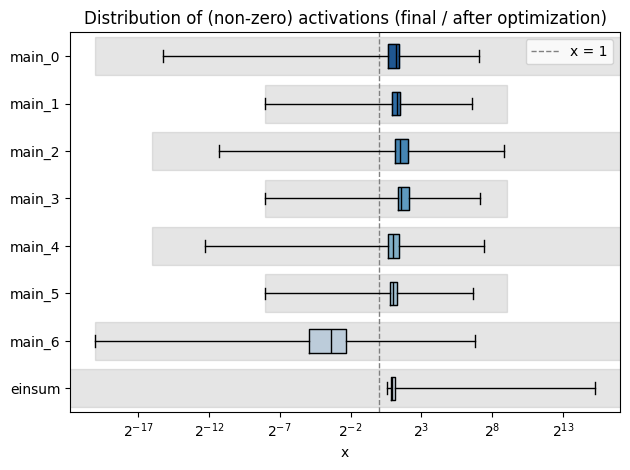

In [13]:
from hls4ml.model.profiling import numerical
hls_model_einsum_torch = flow_matching.return_model_for_hls(mode="einsum")



print(f"Profiling model")
# Profile the model
profile = numerical(model=hls_model_einsum_torch, hls_model=hls_model_einsum, X=X_test_hls[:10000])
# Print the profiling report
print(profile)
# Save the profiling report to a file
with open(f"profiling_report.txt", "w") as f:
    f.write(str(profile))

In [14]:
import torch
full_scores = hls_model_no_einsum.predict(hls_datasets["test"])
# save the scores to a file
np.save("full_model_scores.npy", full_scores)
# save dataset labels to a file
np.save("dataset_labels.npy", dataset.test_labels)
hls_scores =  torch.norm(torch.tensor(full_scores), dim=1).numpy()
hls_auc = roc_auc_score(dataset.test_labels, hls_scores)
hls_ap = average_precision_score(dataset.test_labels, hls_scores)
hls_accuracy = accuracy_score(dataset.test_labels, hls_scores > 10)
print(f"Accuracy: {hls_accuracy:.4f}")
print(f"AUC-ROC: {hls_auc:.4f}")
print(f"Average Precision: {hls_ap:.4f}")
results["hls4ml + torch squared norm"] = {
    "scores": hls_scores,
    "auc": hls_auc,
    "ap": hls_ap,
    "time": 1,
}

temp_scores = torch.tensor(hls_model_no_einsum.predict(hls_datasets["test"]))
hls_scores =  torch.einsum("ij,ij->i", temp_scores, temp_scores).numpy()
hls_auc = roc_auc_score(dataset.test_labels, hls_scores)
hls_ap = average_precision_score(dataset.test_labels, hls_scores)
hls_accuracy = accuracy_score(dataset.test_labels, hls_scores > 10)
print(f"Accuracy: {hls_accuracy:.4f}")
print(f"AUC-ROC: {hls_auc:.4f}")
print(f"Average Precision: {hls_ap:.4f}")
results["hls4ml + torch einsum"] = {
    "scores": hls_scores,
    "auc": hls_auc,
    "ap": hls_ap,
    "time": 1,
}


Accuracy: 0.7130
AUC-ROC: 0.8667
Average Precision: 0.8731
Accuracy: 0.8268
AUC-ROC: 0.8667
Average Precision: 0.8731


In [15]:
hls_scores =  torch.tensor(hls_model_einsum.predict(hls_datasets["test"])).numpy()
hls_auc = roc_auc_score(dataset.test_labels, hls_scores)
hls_ap = average_precision_score(dataset.test_labels, hls_scores)
hls_accuracy = accuracy_score(dataset.test_labels, hls_scores > 10)
print(f"Accuracy: {hls_accuracy:.4f}")
print(f"AUC-ROC: {hls_auc:.4f}")
print(f"Average Precision: {hls_ap:.4f}")
results["hls4ml with einsum"] = {
    "scores": hls_scores,
    "auc": hls_auc,
    "ap": hls_ap,
    "time": 1,
}

Accuracy: 0.8271
AUC-ROC: 0.8643
Average Precision: 0.8719


In [16]:
# Predict anomaly scores
# flow_scores = flow_matching.predict(X_test, mode="vt")
# # print mean and std of scores for normal and anomalous samples
# print(
#     f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
# )
# print(
#     f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
# )
# print(
#     f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
# )
# print(
#     f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
# )
# flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
# flow_ap = average_precision_score(dataset.test_labels, flow_scores)
# flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# # manually compute accuracy
# print(f"Accuracy: {flow_accuracy:.4f}")
# print(f"AUC-ROC: {flow_auc:.4f}")
# print(f"Average Precision: {flow_ap:.4f}")

# results["Flow Matching vt no einsum"] = {
#     "scores": flow_scores,
#     "auc": flow_auc,
#     "ap": flow_ap,
#     "time": 1,
# }

# Predict anomaly scores
flow_scores = flow_matching.predict(X_test, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")

results["Flow Matching vt einsum"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

# # now again in ODE mode
# flow_scores, transformed_data = flow_matching.predict(
#     X_test, mode="ode", time_steps=2, step_size=None, return_transformed_data=True
# )
# # print mean and std of scores for normal and anomalous samples
# print(
#     f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
# )
# print(
#     f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
# )
# print(
#     f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
# )
# print(
#     f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
# )
# flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
# flow_ap = average_precision_score(dataset.test_labels, flow_scores)
# flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 1000)
# # manually compute accuracy
# print(f"Accuracy: {flow_accuracy:.4f}")
# print(f"AUC-ROC: {flow_auc:.4f}")
# print(f"Average Precision: {flow_ap:.4f}")
# results["Flow Matching ode"] = {
#     "scores": flow_scores,
#     "auc": flow_auc,
#     "ap": flow_ap,
#     "time": 1,
# }

Mean score for normal samples: 50.4487
Std score for normal samples: 1480.0261
Mean score for anomalous samples: 34057.2383
Std score for anomalous samples: 195398.5625
Accuracy: 0.8268
AUC-ROC: 0.8667
Average Precision: 0.8731


In [17]:
# Predict anomaly scores
# flow_scores2 = flow_matching.predict(X_test2, mode="vt")
# # print mean and std of scores for normal and anomalous samples
# print(
#     f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
# )
# print(
#     f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
# )
# print(
#     f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
# )
# print(
#     f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
# )
# flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
# flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
# flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# # manually compute accuracy
# print(f"Accuracy: {flow_accuracy2:.4f}")
# print(f"AUC-ROC: {flow_auc2:.4f}")
# print(f"Average Precision: {flow_ap2:.4f}")

# results["Flow Matching2 vt"] = {
#     "scores": flow_scores2,
#     "auc": flow_auc2,
#     "ap": flow_ap2,
#     "time": 1,
# }
# Predict anomaly scores
flow_scores2 = flow_matching.predict(X_test2, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")

results["Flow Matching2 vt einsum"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}

hls_scores =  torch.tensor(hls_model_einsum.predict(X_test_hls2)).numpy()
hls_auc = roc_auc_score(dataset2.test_labels, hls_scores)
hls_ap = average_precision_score(dataset2.test_labels, hls_scores)
hls_accuracy = accuracy_score(dataset2.test_labels, hls_scores > 10)
print(f"Accuracy: {hls_accuracy:.4f}")
print(f"AUC-ROC: {hls_auc:.4f}")
print(f"Average Precision: {hls_ap:.4f}")
results["hls4ml2 with einsum"] = {
    "scores": hls_scores,
    "auc": hls_auc,
    "ap": hls_ap,
    "time": 1,
}
# # now again in ODE mode
# flow_scores2 = flow_matching.predict(
#     X_test2, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
# )
# # print mean and std of scores for normal and anomalous samples
# print(
#     f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
# )
# print(
#     f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
# )
# print(
#     f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
# )
# print(
#     f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
# )
# flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
# flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
# flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 100)
# # manually compute accuracy
# print(f"Accuracy: {flow_accuracy2:.4f}")
# print(f"AUC-ROC: {flow_auc2:.4f}")
# print(f"Average Precision: {flow_ap2:.4f}")
# results["Flow Matching2 ode"] = {
#     "scores": flow_scores2,
#     "auc": flow_auc2,
#     "ap": flow_ap2,
#     "time": 1,
# }

Mean score for normal samples: 67.5139
Std score for normal samples: 3181.6228
Mean score for anomalous samples: 864.8151
Std score for anomalous samples: 12693.0654
Accuracy: 0.7255
AUC-ROC: 0.7969
Average Precision: 0.7586
Accuracy: 0.7295
AUC-ROC: 0.7835
Average Precision: 0.7525


In [18]:
# Predict anomaly scores
# flow_scores3 = flow_matching.predict(X_test3, mode="vt")
# # print mean and std of scores for normal and anomalous samples
# print(
#     f"Mean score for normal samples: {np.mean(flow_scores3[dataset3.test_labels == 0]):.4f}"
# )
# print(
#     f"Std score for normal samples: {np.std(flow_scores3[dataset3.test_labels == 0]):.4f}"
# )
# print(
#     f"Mean score for anomalous samples: {np.mean(flow_scores3[dataset3.test_labels == 1]):.4f}"
# )
# print(
#     f"Std score for anomalous samples: {np.std(flow_scores3[dataset3.test_labels == 1]):.4f}"
# )
# flow_auc3 = roc_auc_score(dataset3.test_labels, flow_scores3)
# flow_ap3 = average_precision_score(dataset3.test_labels, flow_scores3)
# flow_accuracy3 = accuracy_score(dataset3.test_labels, flow_scores3 > 10)
# # manually compute accuracy
# print(f"Accuracy: {flow_accuracy3:.4f}")
# print(f"AUC-ROC: {flow_auc3:.4f}")
# print(f"Average Precision: {flow_ap3:.4f}")
# results["Flow Matching3 vt"] = {
#     "scores": flow_scores3,
#     "auc": flow_auc3,
#     "ap": flow_ap3,
#     "time": 1,
# }

# Predict anomaly scores
flow_scores3 = flow_matching.predict(X_test3, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
flow_auc3 = roc_auc_score(dataset3.test_labels, flow_scores3)
flow_ap3 = average_precision_score(dataset3.test_labels, flow_scores3)
flow_accuracy3 = accuracy_score(dataset3.test_labels, flow_scores3 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy3:.4f}")
print(f"AUC-ROC: {flow_auc3:.4f}")
print(f"Average Precision: {flow_ap3:.4f}")

results["Flow Matching3 vt einsum"] = {
    "scores": flow_scores3,
    "auc": flow_auc3,
    "ap": flow_ap3,
    "time": 1,
}
hls_scores =  torch.tensor(hls_model_einsum.predict(X_test_hls3)).numpy()
hls_auc = roc_auc_score(dataset3.test_labels, hls_scores)
hls_ap = average_precision_score(dataset3.test_labels, hls_scores)
hls_accuracy = accuracy_score(dataset3.test_labels, hls_scores > 10)
print(f"Accuracy: {hls_accuracy:.4f}")
print(f"AUC-ROC: {hls_auc:.4f}")
print(f"Average Precision: {hls_ap:.4f}")
results["hls4ml3 with einsum"] = {
    "scores": hls_scores,
    "auc": hls_auc,
    "ap": hls_ap,
    "time": 1,
}
# now again in ODE mode
# flow_scores3 = flow_matching.predict(
#     X_test3, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
# )
# # print mean and std of scores for normal and anomalous samples
# print(
#     f"Mean score for normal samples: {np.mean(flow_scores3[dataset3.test_labels == 0]):.4f}"
# )
# print(
#     f"Std score for normal samples: {np.std(flow_scores3[dataset3.test_labels == 0]):.4f}"
# )
# print(
#     f"Mean score for anomalous samples: {np.mean(flow_scores3[dataset3.test_labels == 1]):.4f}"
# )
# print(
#     f"Std score for anomalous samples: {np.std(flow_scores3[dataset3.test_labels == 1]):.4f}"
# )
# flow_auc3 = roc_auc_score(dataset3.test_labels, flow_scores3)
# flow_ap3 = average_precision_score(dataset3.test_labels, flow_scores3)
# flow_accuracy3 = accuracy_score(dataset3.test_labels, flow_scores3 > 100)
# # manually compute accuracy
# print(f"Accuracy: {flow_accuracy3:.4f}")
# print(f"AUC-ROC: {flow_auc3:.4f}")
# print(f"Average Precision: {flow_ap3:.4f}")
# results["Flow Matching3 ode"] = {
#     "scores": flow_scores3,
#     "auc": flow_auc3,
#     "ap": flow_ap3,
#     "time": 1,
# }

Mean score for normal samples: 67.5139
Std score for normal samples: 3181.6228
Mean score for anomalous samples: 1354.1364
Std score for anomalous samples: 18533.9238
Accuracy: 0.6233
AUC-ROC: 0.6728
Average Precision: 0.6925
Accuracy: 0.6257
AUC-ROC: 0.6639
Average Precision: 0.6883


In [19]:
# Predict anomaly scores
# flow_scores4 = flow_matching.predict(X_test4, mode="vt")
# # print mean and std of scores for normal and anomalous samples
# print(
#     f"Mean score for normal samples: {np.mean(flow_scores4[dataset4.test_labels == 0]):.4f}"
# )
# print(
#     f"Std score for normal samples: {np.std(flow_scores4[dataset4.test_labels == 0]):.4f}"
# )
# print(
#     f"Mean score for anomalous samples: {np.mean(flow_scores4[dataset4.test_labels == 1]):.4f}"
# )
# print(
#     f"Std score for anomalous samples: {np.std(flow_scores4[dataset4.test_labels == 1]):.4f}"
# )
# flow_auc4 = roc_auc_score(dataset4.test_labels, flow_scores4)
# flow_ap4 = average_precision_score(dataset4.test_labels, flow_scores4)
# flow_accuracy4 = accuracy_score(dataset4.test_labels, flow_scores4 > 10)
# # manually compute accuracy
# print(f"Accuracy: {flow_accuracy4:.4f}")
# print(f"AUC-ROC: {flow_auc4:.4f}")
# print(f"Average Precision: {flow_ap4:.4f}")

# results["Flow Matching4 vt"] = {
#     "scores": flow_scores4,
#     "auc": flow_auc4,
#     "ap": flow_ap4,
#     "time": 1,
# }

# Predict anomaly scores
flow_scores4 = flow_matching.predict(X_test4, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
flow_auc4 = roc_auc_score(dataset4.test_labels, flow_scores4)
flow_ap4 = average_precision_score(dataset4.test_labels, flow_scores4)
flow_accuracy4 = accuracy_score(dataset4.test_labels, flow_scores4 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy4:.4f}")
print(f"AUC-ROC: {flow_auc4:.4f}")
print(f"Average Precision: {flow_ap4:.4f}")

results["Flow Matching4 vt einsum"] = {
    "scores": flow_scores4,
    "auc": flow_auc4,
    "ap": flow_ap4,
    "time": 1,
}
hls_scores =  torch.tensor(hls_model_einsum.predict(X_test_hls4)).numpy()
hls_auc = roc_auc_score(dataset4.test_labels, hls_scores)
hls_ap = average_precision_score(dataset4.test_labels, hls_scores)
hls_accuracy = accuracy_score(dataset4.test_labels, hls_scores > 10)
print(f"Accuracy: {hls_accuracy:.4f}")
print(f"AUC-ROC: {hls_auc:.4f}")
print(f"Average Precision: {hls_ap:.4f}")
results["hls4ml4 with einsum"] = {
    "scores": hls_scores,
    "auc": hls_auc,
    "ap": hls_ap,
    "time": 1,
}
# now again in ODE mode
# flow_scores4 = flow_matching.predict(
#     X_test4, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
# )
# # print mean and std of scores for normal and anomalous samples
# print(
#     f"Mean score for normal samples: {np.mean(flow_scores4[dataset4.test_labels == 0]):.4f}"
# )
# print(
#     f"Std score for normal samples: {np.std(flow_scores4[dataset4.test_labels == 0]):.4f}"
# )
# print(
#     f"Mean score for anomalous samples: {np.mean(flow_scores4[dataset4.test_labels == 1]):.4f}"
# )
# print(
#     f"Std score for anomalous samples: {np.std(flow_scores4[dataset4.test_labels == 1]):.4f}"
# )
# flow_auc4 = roc_auc_score(dataset4.test_labels, flow_scores4)
# flow_ap4 = average_precision_score(dataset4.test_labels, flow_scores4)
# flow_accuracy4 = accuracy_score(dataset4.test_labels, flow_scores4 > 100)
# # manually compute accuracy
# print(f"Accuracy: {flow_accuracy4:.4f}")
# print(f"AUC-ROC: {flow_auc4:.4f}")
# print(f"Average Precision: {flow_ap4:.4f}")
# results["Flow Matching4 ode"] = {
#     "scores": flow_scores4,
#     "auc": flow_auc4,
#     "ap": flow_ap4,
#     "time": 1,
# }

Mean score for normal samples: 67.5139
Std score for normal samples: 3181.6228
Mean score for anomalous samples: 1127.7612
Std score for anomalous samples: 16127.8760
Accuracy: 0.7663
AUC-ROC: 0.8492
Average Precision: 0.8348
Accuracy: 0.7708
AUC-ROC: 0.8371
Average Precision: 0.8296


In [20]:
# print(torch.tensor(results["no einsum"]["scores"]).float()[:10])
# print(torch.tensor(results["Flow Matching vt"]["scores"]).float()[:10])

# print(torch.tensor(results["einsum"]["scores"]).float()[:10])
# print(torch.tensor(results["Flow Matching vt einsum"]["scores"]).float()[:10])

In [21]:
# plt.hist(hls_scores["test"], bins=100, range=(-10,1000))
# plt.hist(results["Flow Matching vt einsum"]["scores"], bins=100, range=(-10,1000))
# idxs = torch.abs(torch.tensor(results["hls4ml einsum"]["scores"][:100000]).float()-torch.tensor(results["Flow Matching vt einsum"]["scores"][:100000]).float())>1
#torch.allclose(torch.tensor(hls_scores["test"]).float(), torch.tensor(results["Flow Matching vt einsum"]["scores"]).float() )

## 5. Model Comparison and Visualization

hls4ml + torch squared norm
hls4ml + torch einsum
hls4ml with einsum
Flow Matching vt einsum
Flow Matching2 vt einsum
hls4ml2 with einsum


ValueError: Found input variables with inconsistent numbers of samples: [115969, 740544]

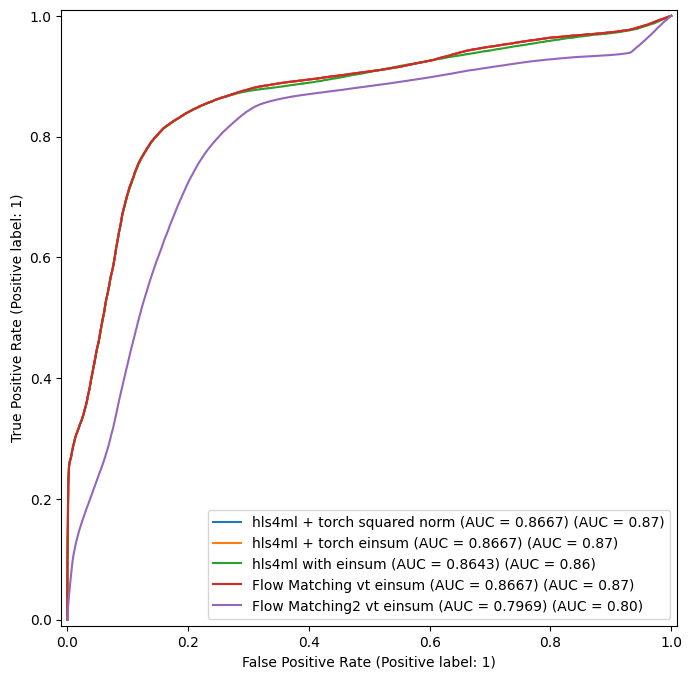

In [22]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
# remove "Flow Mathcing2" form results
for name, result in results.items():
    print(name)
    if (name == "Flow Matching2 vt") | (name == "Flow Matching2 vt einsum") | (name == "Flow Matching2 ode"):
        # use the second dataset for this model
        RocCurveDisplay.from_predictions(
            dataset2.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name == "Flow Matching3 vt") | (name == "Flow Matching3 vt einsum") | (name == "Flow Matching3 ode"):
        # use the third dataset for this model
        RocCurveDisplay.from_predictions(
            dataset3.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name == "Flow Matching4 vt") | (name == "Flow Matching4 vt einsum") | (name == "Flow Matching4 ode"):
        # use the fourth dataset for this model
        RocCurveDisplay.from_predictions(
            dataset4.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    else:
        RocCurveDisplay.from_predictions(
            dataset.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )

plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.title("ROC Curves Comparison")
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if (name == "Flow Matching2 vt") | (name == "Flow Matching2 vt einsum") | (name == "Flow Matching2 ode"):
        # use the second dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset2.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name == "Flow Matching3 vt") | (name == "Flow Matching3 vt einsum") | (name == "Flow Matching3 ode"):
        # use the third dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset3.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name == "Flow Matching4 vt") | (name == "Flow Matching4 vt einsum") | (name == "Flow Matching4 ode"):
        # use the fourth dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset4.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    else:
        precision, recall, _ = precision_recall_curve(
            dataset.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

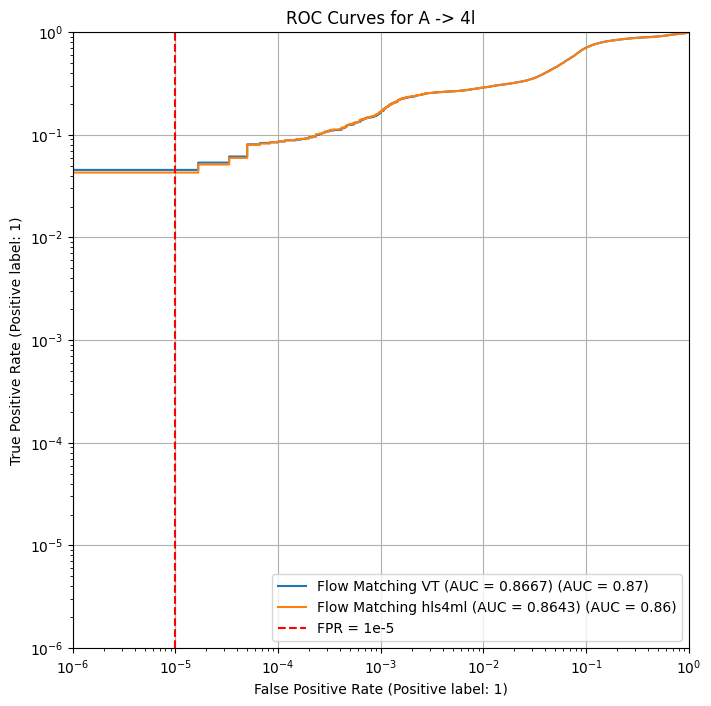

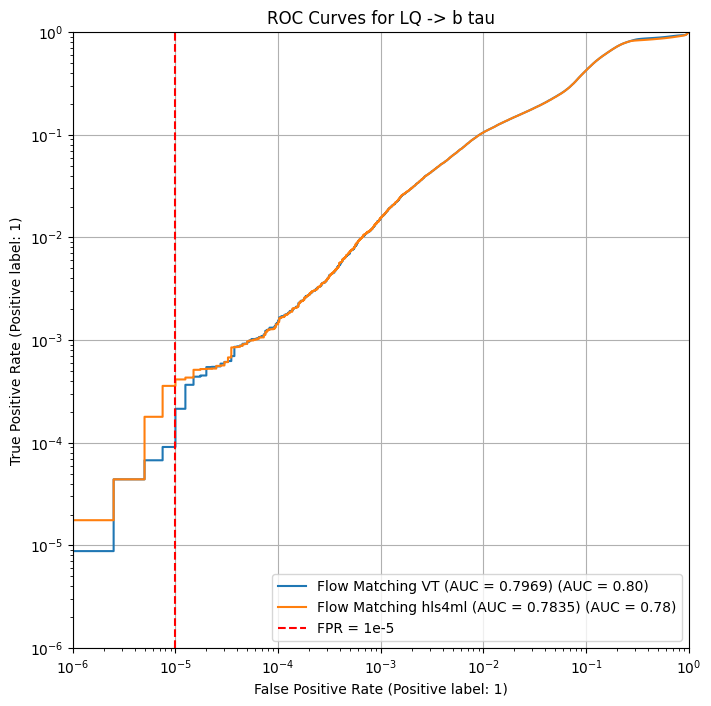

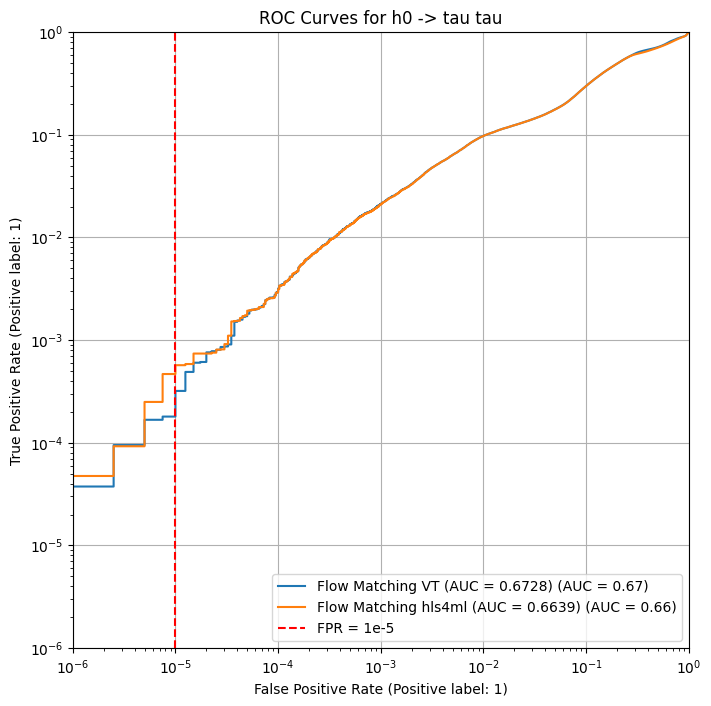

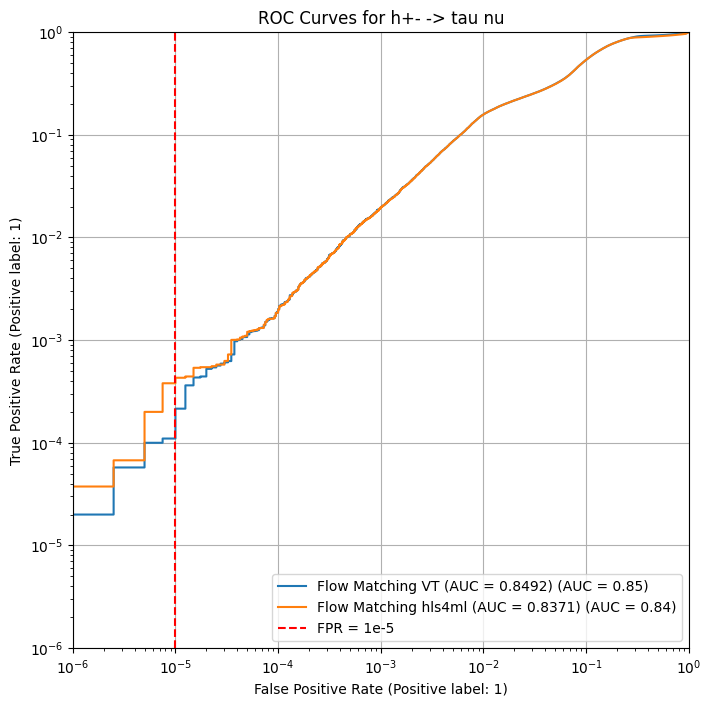

In [25]:
# Define dataset names and corresponding results prefixes/labels
dataset_info = [
    {"name": "A -> 4l", "prefix": "Flow Matching ", "labels": dataset.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "hls4ml": "hls4ml with einsum"},
    {"name": "LQ -> b tau", "prefix": "Flow Matching2 ", "labels": dataset2.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "hls4ml": "hls4ml2 with einsum"},
    {"name": "h0 -> tau tau", "prefix": "Flow Matching3 ", "labels": dataset3.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "hls4ml": "hls4ml3 with einsum"},
    {"name": "h+- -> tau nu", "prefix": "Flow Matching4 ", "labels": dataset4.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "hls4ml": "hls4ml4 with einsum"},
    # Add entries for models trained with type index if they exist and need plotting
    # {"name": "A -> 4l (with type idx)", "prefix": "Flow Matching ", "labels": dataset.test_labels, "suffix_vt": "vt with type idx", "suffix_ode": "ode with type idx"},
    # {"name": "LQ -> b tau (with type idx)", "prefix": "Flow Matching2 ", "labels": dataset2.test_labels, "suffix_vt": "vt with type idx", "suffix_ode": "ode with type idx"},
]

for info in dataset_info:
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    dataset_name = info["name"]
    prefix = info["prefix"]
    labels = info["labels"]
    
    # Plot vt mode
    vt_key = prefix + info["suffix_vt"]
    if vt_key in results:
        result_vt = results[vt_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_vt["scores"],
            name=f"Flow Matching VT (AUC = {result_vt['auc']:.4f})",
            ax=ax,
        )
    
    # Plot ode mode
    ode_key = prefix + info["suffix_ode"]
    if ode_key in results:
        result_ode = results[ode_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_ode["scores"],
            name=f"Flow Matching ODE (AUC = {result_ode['auc']:.4f})",
            ax=ax,
        )
    
        # Plot ode mode
    hls4ml_key = info["hls4ml"]
    if hls4ml_key in results:
        result_ode = results[hls4ml_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_ode["scores"],
            name=f"Flow Matching hls4ml (AUC = {result_ode['auc']:.4f})",
            ax=ax,
        )
        
    # Add Isolation Forest for the first dataset for comparison
    if dataset_name == "A -> 4l" and "Isolation Forest" in results:
         result_iso = results["Isolation Forest"]
         RocCurveDisplay.from_predictions(
             labels,
             result_iso["scores"],
             name=f"Isolation Forest (AUC = {result_iso['auc']:.4f})",
             ax=ax,
         )

    plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim([1e-6, 1])
    plt.ylim([1e-6, 1])
    plt.title(f"ROC Curves for {dataset_name}")
    plt.grid(True)
    plt.legend()
    plt.show()

Isolation Forest
Flow Matching vt
Flow Matching vt einsum
Flow Matching ode
Flow Matching2 vt
Flow Matching2 vt einsum
Flow Matching2 ode
Flow Matching3 vt einsum
Flow Matching3 ode
Flow Matching4 vt
Flow Matching4 vt einsum
Flow Matching4 ode


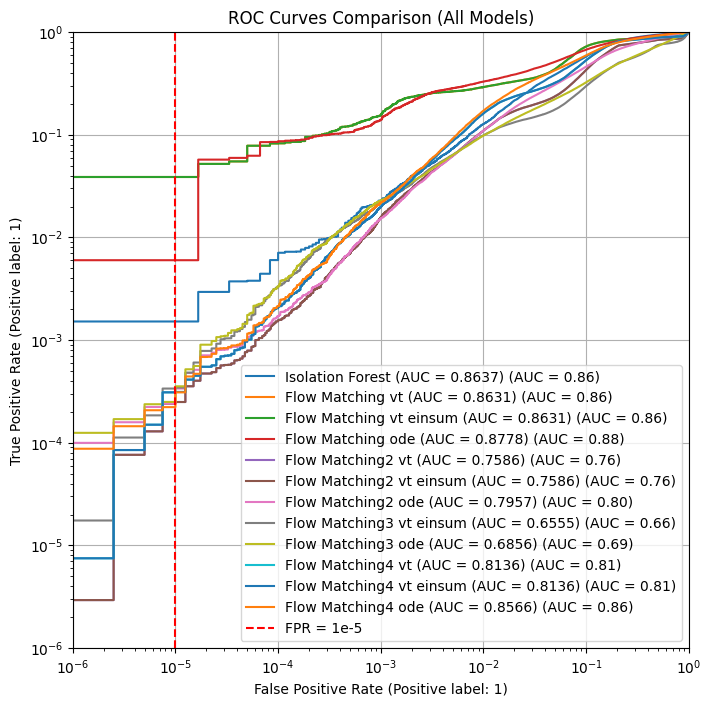

/home/fvaselli/miniconda3/envs/AD/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


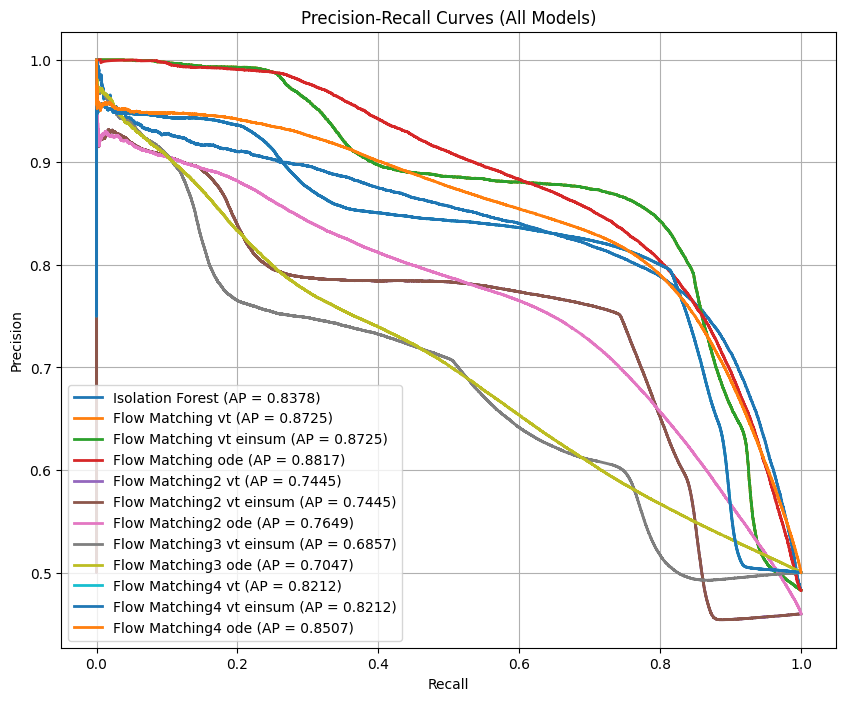

In [ ]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
# remove "Flow Mathcing2" form results
for name, result in results.items():
    print(name)
    if (name.startswith("Flow Matching2 vt")) | (name.startswith("Flow Matching2 ode")):
        # use the second dataset for this model
        RocCurveDisplay.from_predictions(
            dataset2.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name.startswith("Flow Matching3 vt")) | (name.startswith("Flow Matching3 ode")):
        # use the third dataset for this model
        RocCurveDisplay.from_predictions(
            dataset3.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name.startswith("Flow Matching4 vt")) | (name.startswith("Flow Matching4 ode")):
        # use the fourth dataset for this model
        RocCurveDisplay.from_predictions(
            dataset4.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    else:
        RocCurveDisplay.from_predictions(
            dataset.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )

plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.title("ROC Curves Comparison (All Models)") # Updated title
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if (name.startswith("Flow Matching2 vt")) | (name.startswith("Flow Matching2 ode")):
        # use the second dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset2.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name.startswith("Flow Matching3 vt")) | (name.startswith("Flow Matching3 ode")):
        # use the third dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset3.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name.startswith("Flow Matching4 vt")) | (name.startswith("Flow Matching4 ode")):
        # use the fourth dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset4.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    else:
        precision, recall, _ = precision_recall_curve(
            dataset.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (All Models)") # Updated title
plt.legend()
plt.grid(True)
plt.show()

## 6. Score Distributions

In [ ]:
# Visualize anomaly scores distribution
plt.figure(figsize=(12, 6))

for i, (name, result) in enumerate(results.items(), 1):
    if name != "Flow Matching":
        continue
    plt.subplot(1, 1, 1)

    # Separate scores for normal and anomaly classes
    if name == "Flow Matching2":
        # use the second dataset for this model
        normal_scores = result["scores"][dataset2.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset2.test_labels == 1]
    else:
        normal_scores = result["scores"][dataset.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset.test_labels == 1]

    if any(anomaly_scores > 1000):
        anomaly_scores[anomaly_scores > 1000] = 1000
        normal_scores[normal_scores > 1000] = 1000
        print(f"mean score for normal samples: {np.median(normal_scores)}")
        print(f"mean score for anomalous samples: {np.mean(anomaly_scores)}")
    # Plot histograms
    sns.histplot(normal_scores, color="blue", alpha=0.5, label="Normal", bins=100)
    sns.histplot(anomaly_scores, color="red", alpha=0.5, label="Anomaly", bins=100)

    plt.title(f"{name} Score Distribution")
    plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

torch.Size([2, 5, 57])
torch.Size([2, 5, 57])


Text(0.5, 0.01, '○: Initial state   •: Intermediate states   ★: Final state')

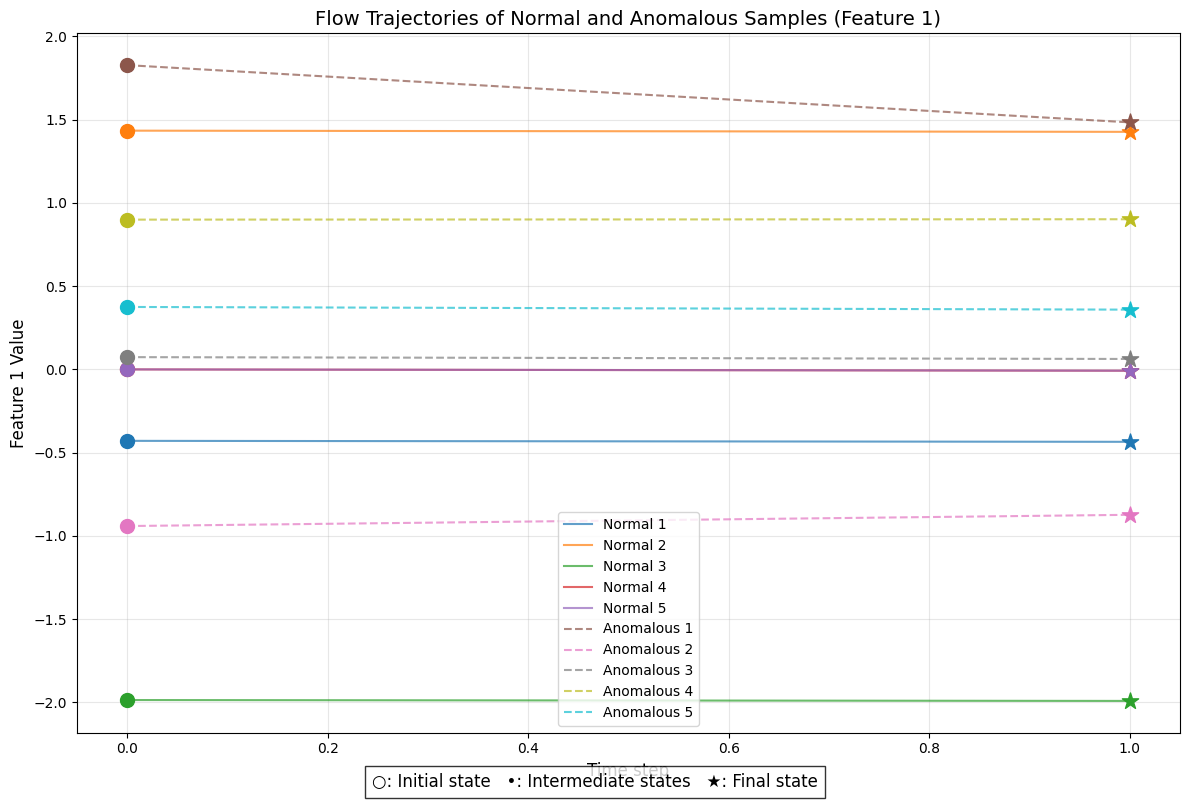

In [ ]:
# try and plot some trajectories for normal and anomalous samples
# get the indices of the normal and anomalous samples
normal_indices = np.where(dataset.test_labels == 0)[0]
anomalous_indices = np.where(dataset.test_labels == 1)[0]
# get the first 5 indices of each
normal_indices = normal_indices[:5]
anomalous_indices = anomalous_indices[:5]
# plot the trajectories for the normal samples
normal_trajectories = flow_matching.return_trajectories(
    X_test[normal_indices],
    mode="ODE",
    time_steps=2,
).swapaxes(0, 1)
anom_trajectories = flow_matching.return_trajectories(
    X_test[anomalous_indices],
    mode="ODE",
    time_steps=2,
).swapaxes(0, 1)

# Create a figure for the first feature trajectory visualization
plt.figure(figsize=(12, 8))

# Plot the trajectories
for i, trajectory in enumerate(normal_trajectories):
    plt.plot(trajectory[:, 4], label=f"Normal {i + 1}", color=f"C{i}", alpha=0.7)
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i}",
        s=150,
        zorder=10,
    )

for i, trajectory in enumerate(anom_trajectories):
    plt.plot(
        trajectory[:, 4],
        label=f"Anomalous {i + 1}",
        linestyle="--",
        color=f"C{i + 5}",
        alpha=0.7,
    )
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i + 5}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i + 5}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i + 5}",
        s=150,
        zorder=10,
    )

# Add visual enhancements
plt.title("Flow Trajectories of Normal and Anomalous Samples (Feature 1)", fontsize=14)
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Feature 1 Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc="best", fontsize=10)
plt.tight_layout()

# Add a text annotation explaining the markers
plt.figtext(
    0.5,
    0.01,
    "○: Initial state   •: Intermediate states   ★: Final state",
    ha="center",
    fontsize=12,
    bbox={"facecolor": "white", "alpha": 0.8, "pad": 5},
)

## 7. Results Summary

In [ ]:
# Create a summary table
print("==== Summary of Results ====")
print(f"{'Model':<20} {'AUC-ROC':<10} {'Avg Precision':<15} {'Training Time (s)':<15}")
print("-" * 60)
for name, result in results.items():
    print(
        f"{name:<20} {result['auc']:<10.4f} {result['ap']:<15.4f} {result['time']:<15.2f}"
    )

==== Summary of Results ====
Model                AUC-ROC    Avg Precision   Training Time (s)
------------------------------------------------------------
Isolation Forest     0.8637     0.8378          13.96          
Flow Matching vt     0.8631     0.8725          1.00           
Flow Matching vt einsum 0.8631     0.8725          1.00           
Flow Matching ode    0.8778     0.8817          1.00           
Flow Matching2 vt    0.7586     0.7445          1.00           
Flow Matching2 vt einsum 0.7586     0.7445          1.00           
Flow Matching2 ode   0.7957     0.7649          1.00           
Flow Matching3 vt einsum 0.6555     0.6857          1.00           
Flow Matching3 ode   0.6856     0.7047          1.00           
Flow Matching4 vt    0.8136     0.8212          1.00           
Flow Matching4 vt einsum 0.8136     0.8212          1.00           
Flow Matching4 ode   0.8566     0.8507          1.00           


In [ ]:
# Set paths to dataset files
path_bkg = (
    "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
)
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=3500000, n_test=60000, discard_type_idx=False)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")

# dataset 2 with different anomaly process
path_anom2 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset2 = _load_h5_challenge_dataset(
    path_bkg, path_anom2, n_train=100000, n_test=400000, discard_type_idx=False
)
# Print dataset information
print(f"Training set shape: {dataset2.train.shape}")
print(f"Test set shape: {dataset2.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset2.test_labels)}")

Loading datasets...
Training set shape: (3500000, 76)
Test set shape: (115969, 76)
Number of anomalies in test set: 55969.0
Loading datasets...
Training set shape: (100000, 76)
Test set shape: (740544, 76)
Number of anomalies in test set: 340544.0


In [ ]:
# Preprocess data with standardization
print("Preprocessing data...")
preprocessor = Preprocessor([StandardScalerFunction()])
X_train = preprocessor.transform(dataset.train, fit=True)
X_test = preprocessor.transform(dataset.test)
print("Done")
X_test2 = preprocessor.transform(dataset2.test)

Preprocessing data...
Done


In [ ]:
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
# flow_matching  = FlowMatchingAnomalyDetector(
#     input_dim=X_train.shape[1],
#     hidden_dim=config["hidden_dim"],
#     model_type=config["model_type"],
#     num_layers=config["num_layers"],
#     dropout_rate=config["dropout_rate"],
#     use_batch_norm=config["use_batch_norm"],
#     lr=config["lr"],
#     batch_size= config["batch_size"],
#     iterations=config["iterations"],
#     print_every=config["print_every"],
#     device=config["device"],
# )
# flow_matching.load("flow_matching_model.pt")

print("Training Flow Matching (this may take a while)...")
# load the model config from the config file
# use absolute path to avoid issues with relative paths: get my parent folder, then go to fad/models/configs/flow_matching.yaml
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
start_time = time.time()
flow_matching = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size=config["batch_size"],
    reflow_steps=config["reflow_steps"],
    reflow_batches=config["reflow_batches"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
)
flow_matching.fit(X_train, mode="OT", reflow=False)
flow_time = time.time() - start_time
print(f"Training time: {flow_time:.2f} seconds")

Training Flow Matching (this may take a while)...


KeyboardInterrupt: 

In [ ]:
# Predict anomaly scores
flow_scores = flow_matching.predict(X_test, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")

results["Flow Matching vt with type idx"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

# now again in ODE mode
flow_scores, transformed_data = flow_matching.predict(
    X_test, mode="ode", time_steps=2, step_size=None, return_transformed_data=True
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")
results["Flow Matching ode with type idx"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

Mean score for normal samples: 4.2258
Std score for normal samples: 6.6523
Mean score for anomalous samples: 63.8534
Std score for anomalous samples: 134.7336
Accuracy: 0.7751
AUC-ROC: 0.8513
Average Precision: 0.8733
time grid: tensor([1., 0.])
Mean score for normal samples: 89.3331
Std score for normal samples: 892.9461
Mean score for anomalous samples: 8008.4399
Std score for anomalous samples: 39312.0625
Accuracy: 0.4826
AUC-ROC: 0.8942
Average Precision: 0.8956


In [ ]:
# Predict anomaly scores
flow_scores2 = flow_matching.predict(X_test2, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")

results["Flow Matching2 vt with type idx"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}
# now again in ODE mode
flow_scores2 = flow_matching.predict(
    X_test2, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")
results["Flow Matching2 ode with type idx"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}

Mean score for normal samples: 4.2672
Std score for normal samples: 7.4291
Mean score for anomalous samples: 12.8378
Std score for anomalous samples: 25.8525
Accuracy: 0.6596
AUC-ROC: 0.7637
Average Precision: 0.7508
time grid: tensor([1., 0.])
Mean score for normal samples: 62.3997
Std score for normal samples: 590.0229
Mean score for anomalous samples: 291.9750
Std score for anomalous samples: 3986.1611
Accuracy: 0.4599
AUC-ROC: 0.8036
Average Precision: 0.7746


In [ ]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
# remove "Flow Mathcing2" form results
for name, result in results.items():
    print(name)
    if (name.startswith("Flow Matching2 vt")) | (name.startswith("Flow Matching2 ode")):
        # use the second dataset for this model
        RocCurveDisplay.from_predictions(
            dataset2.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name.startswith("Flow Matching3 vt")) | (name.startswith("Flow Matching3 ode")):
        # use the third dataset for this model
        RocCurveDisplay.from_predictions(
            dataset3.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name.startswith("Flow Matching4 vt")) | (name.startswith("Flow Matching4 ode")):
        # use the fourth dataset for this model
        RocCurveDisplay.from_predictions(
            dataset4.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    else:
        RocCurveDisplay.from_predictions(
            dataset.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )

plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.title("ROC Curves Comparison (All Models)") # Updated title
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if (name.startswith("Flow Matching2 vt")) | (name.startswith("Flow Matching2 ode")):
        # use the second dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset2.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name.startswith("Flow Matching3 vt")) | (name.startswith("Flow Matching3 ode")):
        # use the third dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset3.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name.startswith("Flow Matching4 vt")) | (name.startswith("Flow Matching4 ode")):
        # use the fourth dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset4.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    else:
        precision, recall, _ = precision_recall_curve(
            dataset.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (All Models)") # Updated title
plt.legend()
plt.grid(True)
plt.show()